# Analisis de Recencia

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymysql

from sklearn.cluster import KMeans

## Data Wrangling

In [19]:
host='localhost'
db='RFM_unifin'
user_db='root'
pass_db=''

conn=pymysql.connect(host=host, user=user_db, passwd=pass_db, db=db)

cur=conn.cursor()

query="SELECT Cuenta,Last_date,Num_Tickets,Monto FROM Transacciones;"

cur.execute(query),

res = cur.fetchall()

cur.close()

conn.close()

headers=['Id','Date','Frecuency','Money']

id_RFM=headers[0]
target_R=headers[1]
target_F=headers[2]
target_M=headers[3]

dataset_dummy={}
filas=0

for h in headers:
    dataset_dummy[h]=[]
    
if(len(res)>0):
    for r in res:
        filas+=1
        for i in range(len(headers)):
            dataset_dummy[headers[i]].append(r[i])

print('El numero de filas de este dataset es de:'+str(filas))

dataset=pd.DataFrame(dataset_dummy)#convertir diccionario en dataset

dataset[target_R]=dataset[target_R].astype(str).str.replace('-', '')
dataset[target_R]=dataset[target_R].astype(str).astype(int)

dataset.head()  

El numero de filas de este dataset es de:998


,Id,Date,Frecuency,Money
0,1,20151216,10,1000.0
1,2,20151214,2,490.0
2,3,20151213,7,287.0
3,4,20151212,4,259.0
4,5,20151211,6,866.0


**-------------------------------------------------------------------------------------------------------------**

In [20]:
print(dataset.shape)
print(dataset.dtypes)

dataset=dataset.sort_values(by=target_M,ascending=True)
dataset = dataset.reset_index(drop=True)

dataset.head()

(998, 4)
Id             int64
Date           int64
Frecuency      int64
Money        float64
dtype: object


,Id,Date,Frecuency,Money
0,990,20130331,3,1.0
1,785,20131022,10,1.0
2,343,20150107,2,4.0
3,10,20151206,5,4.0
4,625,20140331,7,4.0


In [21]:
#Normalizacion de Dataset
#se mecesitan todas la variables numericas
#dataset_norm=(dataset-dataset.min())/(dataset.max()-dataset.min())
#dataset_norm.head()

## Creacion y ajustes de Clusters

In [22]:
model_m=KMeans(n_clusters=5).fit(dataset[[target_M]])
clust_m=pd.Series(model_m.labels_)
dataset['p_m']=clust_m

dataset.head()

,Id,Date,Frecuency,Money,p_m
0,990,20130331,3,1.0,2
1,785,20131022,10,1.0,2
2,343,20150107,2,4.0,2
3,10,20151206,5,4.0,2
4,625,20140331,7,4.0,2


In [23]:
lim_clusts=[]
for i in range(0,5):
    x=dataset[dataset['p_m']==i]
    lim_clusts.append(x[target_M].max())
lim_clusts.sort()   

print(lim_clusts)

[183.0, 390.0, 587.0, 786.0, 1000.0]


In [24]:
lim1=lim_clusts[0]
lim2=lim_clusts[1]
lim3=lim_clusts[2]
lim4=lim_clusts[3]
lim5=lim_clusts[4]

print(lim1)
print(lim2)
print(lim3)
print(lim4)
print(lim5)

183.0
390.0
587.0
786.0
1000.0


In [25]:
dataset.loc[(dataset[target_M] <= lim1), 'M'] = 1
dataset.loc[(dataset[target_M] <= lim2) & (dataset[target_M] > lim1), 'M'] = 2
dataset.loc[(dataset[target_M] <= lim3) & (dataset[target_M] > lim2), 'M'] = 3
dataset.loc[(dataset[target_M] <= lim4) & (dataset[target_M] > lim3), 'M'] = 4
dataset.loc[(dataset[target_M] <= lim5) & (dataset[target_M] > lim4), 'M'] = 5

dataset=dataset.drop(['p_m'], axis=1)

dataset.head()

,Id,Date,Frecuency,Money,M
0,990,20130331,3,1.0,1.0
1,785,20131022,10,1.0,1.0
2,343,20150107,2,4.0,1.0
3,10,20151206,5,4.0,1.0
4,625,20140331,7,4.0,1.0


## Actualizacion de DB

In [26]:
#conn=pymysql.connect(host=host, user=user_db, passwd=pass_db, db=db)

#cur=conn.cursor()
#for index,row in dataset.iterrows():
#	query="Update Transacciones set R="+str(int(row['M']))+" where Cuenta="+str(int(row[id_RFM]))+";"
#	cur.execute(query)

#conn.commit()
#cur.close()
#conn.close()

## Conclusion

In [27]:
d=dataset['M'].value_counts().to_dict()
m_frame=pd.DataFrame([d], columns=d.keys())
m_frame

,5.0,3.0,4.0,2.0,1.0
0,213,203,199,199,184


[]

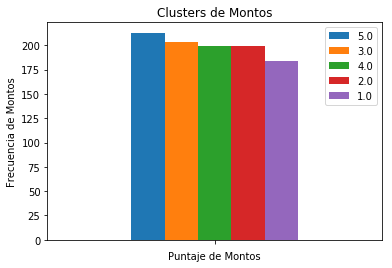

In [28]:
ax=m_frame.plot(kind='bar')
ax.set_title('Clusters de Montos')
ax.set_xlabel('Puntaje de Montos')
ax.set_ylabel('Frecuencia de Montos')
ax.set_xticklabels('')

Text(0.5, 1.0, 'Distribuicion de Montos y Clusters')

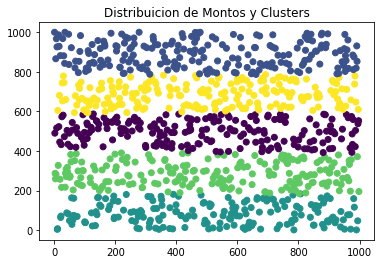

In [29]:
plt.scatter(x=dataset[id_RFM],y=dataset[target_M],c=clust_m)
plt.title('Distribuicion de Montos y Clusters')

In [30]:
for i in m_frame.columns.values:
    x=dataset[dataset['M']==i]
    print('Para el Cluster con valor en R=',i)
    print('Los Montos van de ',x[target_M].min(),' a ',x[target_M].max())
    print('')

Para el Cluster con valor en R= 5.0
Los Montos van de  787.0  a  1000.0

Para el Cluster con valor en R= 3.0
Los Montos van de  392.0  a  587.0

Para el Cluster con valor en R= 4.0
Los Montos van de  594.0  a  786.0

Para el Cluster con valor en R= 2.0
Los Montos van de  185.0  a  390.0

Para el Cluster con valor en R= 1.0
Los Montos van de  1.0  a  183.0

